In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy import stats

from datetime import datetime

from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('marketing_campaign_data.csv', index_col = [0])

In [ ]:
df.shape

(2240, 29)

In [ ]:
df.sample(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
214,0,1985,S1,Menikah,70951000.0,0,0,04-05-2013,66,239000,...,1,0,0,0,0,0,0,3,11,0
859,1031,1989,D3,Menikah,85710000.0,0,0,05-05-2013,5,600000,...,2,0,0,1,0,0,0,3,11,0
1750,3571,1961,S3,Bertunangan,63342000.0,0,1,16-10-2012,48,918000,...,6,0,1,0,0,0,0,3,11,1
792,3479,1950,S1,Lajang,16813000.0,0,0,19-07-2013,49,4000,...,7,1,0,0,0,0,0,3,11,0
243,9529,1990,S1,Menikah,73687000.0,0,0,28-11-2013,8,559000,...,2,0,0,0,1,0,0,3,11,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntCoke              2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

# Feature Engineering

In [ ]:
# Feature Engineering
df['Conversion_Rate'] = df['Response'] / df['NumWebVisitsMonth']
df['Age'] = 2023 - df['Year_Birth']
df['Total_Children'] = df['Kidhome'] + df['Teenhome']
df['Total_Spending'] = df['MntCoke'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['Total_Transactions'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

# Add Total_Campaign
campaign_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Total_Campaign'] = df[campaign_columns].sum(axis=1)

In [ ]:
# Define age groups

age_bins = [0, 30, 60, float('inf')]
age_labels = ['(0-30)', '(30-60)', '(>=60)']
df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)

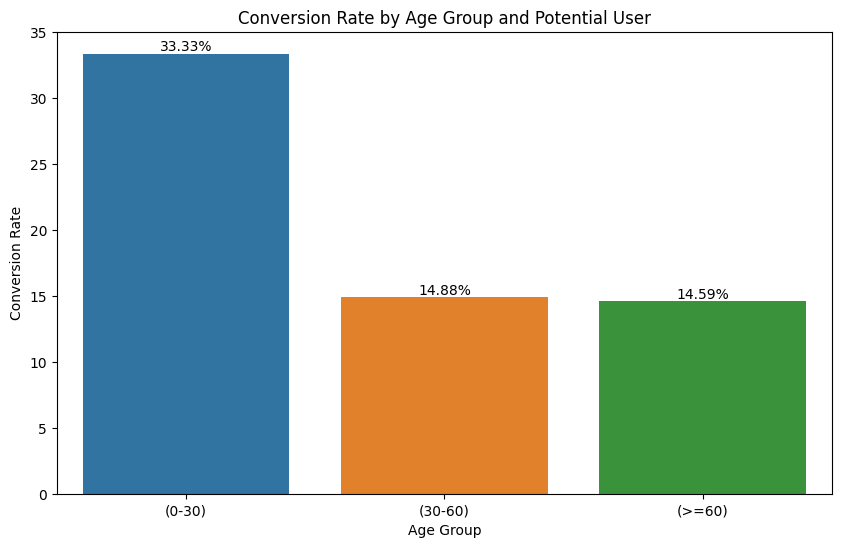

In [ ]:
# Define potential user type based on Conversion Rate threshold
conversion_threshold = 0.1
df['Potential_User'] = df['Conversion_Rate'] >= conversion_threshold
percentage = df.groupby('Age_Group')['Potential_User'].mean() * 100


# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=percentage.index, y=percentage.values)
sns.barplot(x='Age_Group', y='Conversion_Rate', data=df, ci=None)

plt.title("Conversion Rate by Age Group and Potential User")
plt.xlabel("Age Group")
plt.ylabel("Conversion Rate")
# Display percentages on the bars
for i, value in enumerate(percentage):
    ax.text(i, value, f'{value:.2f}%', ha='center', va='bottom', color='black')

plt.show()

In [ ]:
df.head(20)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,...,Z_Revenue,Response,Conversion_Rate,Age,Total_Children,Total_Spending,Total_Transactions,Total_Campaign,Age_Group,Potential_User
0,5524,1957,S1,Lajang,58138000.0,0,0,04-09-2012,58,635000,...,11,1,0.142857,66,0,1617000,25,0,(>=60),True
1,2174,1954,S1,Lajang,46344000.0,1,1,08-03-2014,38,11000,...,11,0,0.000000,69,2,27000,6,0,(>=60),False
2,4141,1965,S1,Bertunangan,71613000.0,0,0,21-08-2013,26,426000,...,11,0,0.000000,58,0,776000,21,0,(30-60),False
3,6182,1984,S1,Bertunangan,26646000.0,1,0,10-02-2014,26,11000,...,11,0,0.000000,39,1,53000,8,0,(30-60),False
4,5324,1981,S3,Menikah,58293000.0,1,0,19-01-2014,94,173000,...,11,0,0.000000,42,1,422000,19,0,(30-60),False
5,7446,1967,S2,Bertunangan,62513000.0,0,1,09-09-2013,16,520000,...,11,0,0.000000,56,1,716000,22,0,(30-60),False
6,965,1971,S1,Cerai,55635000.0,0,1,13-11-2012,34,235000,...,11,0,0.000000,52,1,590000,21,0,(30-60),False
7,6177,1985,S3,Menikah,33454000.0,1,0,08-05-2013,32,76000,...,11,0,0.000000,38,1,169000,10,0,(30-60),False
8,4855,1974,S3,Bertunangan,30351000.0,1,0,06-06-2013,19,14000,...,11,1,0.111111,49,1,46000,6,0,(30-60),True
9,5899,1950,S3,Bertunangan,5648000.0,1,1,13-03-2014,68,28000,...,11,0,0.000000,73,2,49000,2,1,(>=60),False


# Exploratory Data Analysis

In [ ]:
# List of numeric columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# List of categorical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Display the lists
print("Numeric Columns:", num_cols)
print("Categorical Columns:", cat_cols)

Numeric Columns: ['ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntCoke', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Conversion_Rate', 'Age', 'Total_Children', 'Total_Spending', 'Total_Transactions', 'Total_Campaign']
Categorical Columns: ['Education', 'Marital_Status', 'Dt_Customer']


In [ ]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5.592160e+03,3.246662e+03,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1.968806e+03,1.198407e+01,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,5.224725e+07,2.517308e+07,1730000.0,35303000.00,51381500.0,68522000.00,666666000.0
Kidhome,2240.0,4.441964e-01,5.383981e-01,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,5.062500e-01,5.445382e-01,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,4.910938e+01,2.896245e+01,0.0,24.00,49.0,74.00,99.0
MntCoke,2240.0,3.039357e+05,3.365974e+05,0.0,23750.00,173500.0,504250.00,1493000.0
MntFruits,2240.0,2.630223e+04,3.977343e+04,0.0,1000.00,8000.0,33000.00,199000.0
MntMeatProducts,2240.0,1.669500e+05,2.257154e+05,0.0,16000.00,67000.0,232000.00,1725000.0
MntFishProducts,2240.0,3.752545e+04,5.462898e+04,0.0,3000.00,12000.0,50000.00,259000.0


In [ ]:
for col in cat_cols:
    print(col)
    print(df[col].value_counts())
    print()

Education
S1     1127
S3      486
S2      370
D3      203
SMA      54
Name: Education, dtype: int64

Marital_Status
Menikah        864
Bertunangan    580
Lajang         484
Cerai          232
Janda           77
Duda             3
Name: Marital_Status, dtype: int64

Dt_Customer
31-08-2012    12
12-09-2012    11
14-02-2013    11
12-05-2014    11
20-08-2013    10
              ..
05-08-2012     1
18-11-2012     1
25-05-2013     1
14-04-2013     1
09-01-2014     1
Name: Dt_Customer, Length: 663, dtype: int64



In [ ]:
df[cat_cols].describe().T

,count,unique,top,freq
Education,2240,5,S1,1127
Marital_Status,2240,6,Menikah,864
Dt_Customer,2240,663,31-08-2012,12


## Univariate Analysis

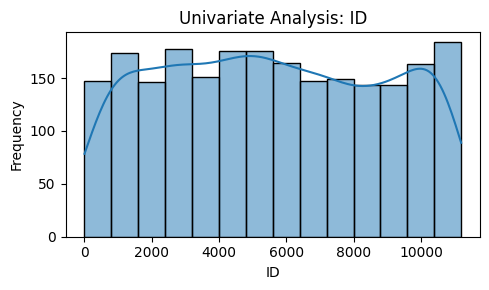

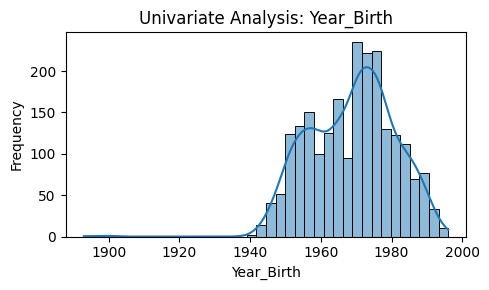

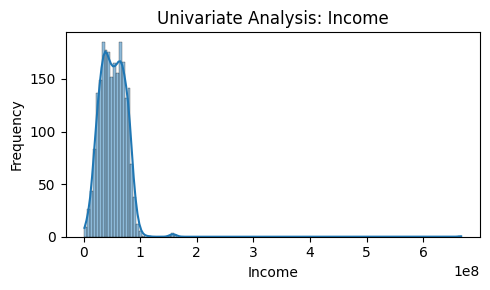

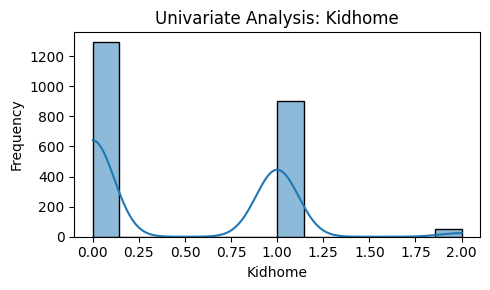

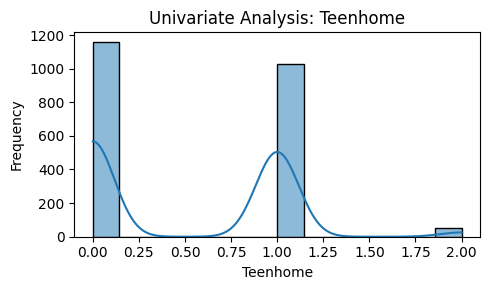

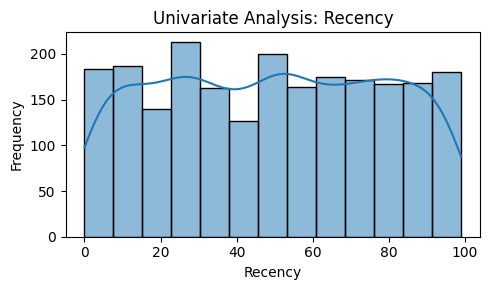

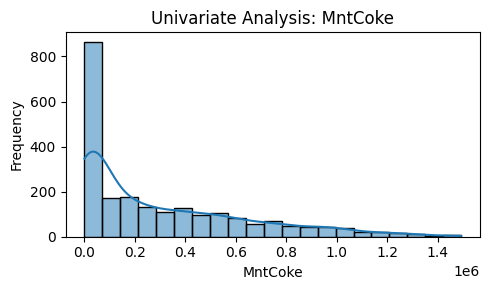

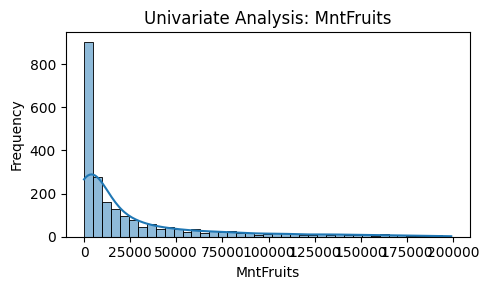

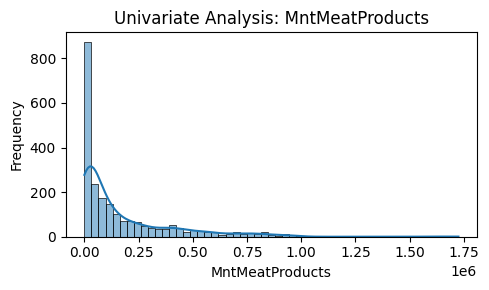

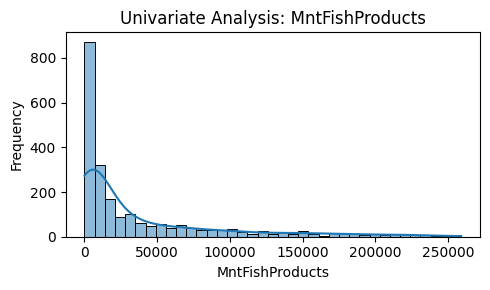

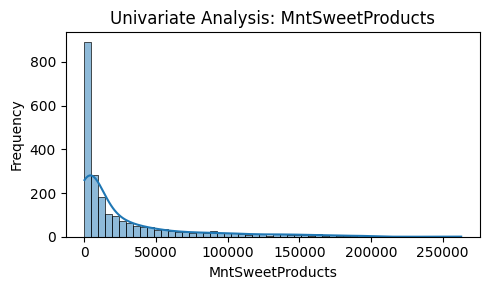

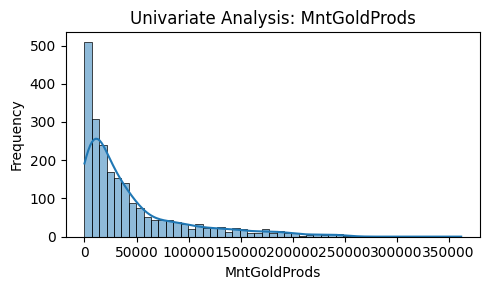

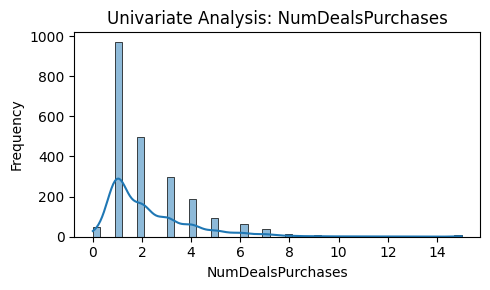

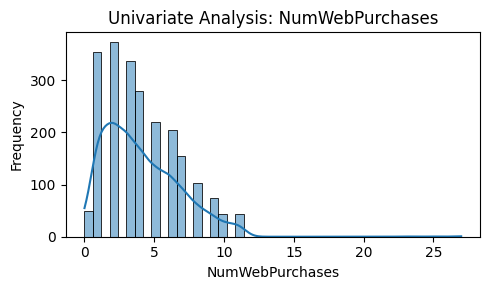

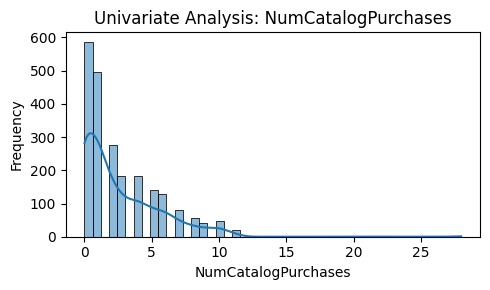

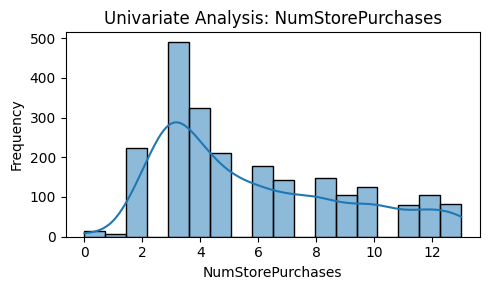

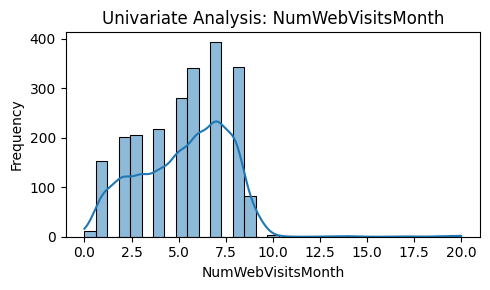

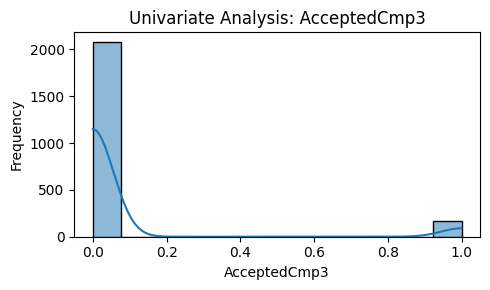

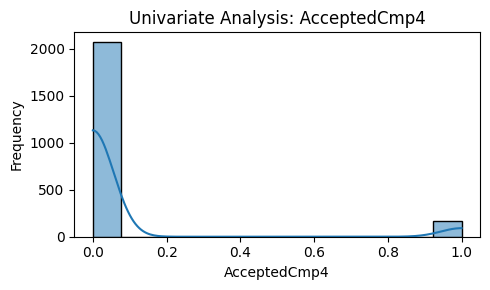

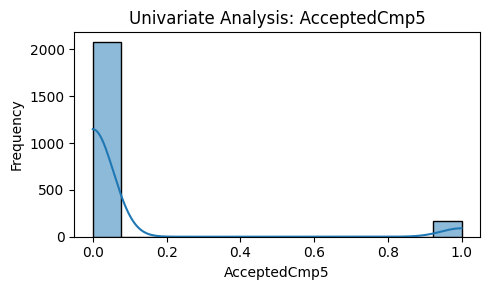

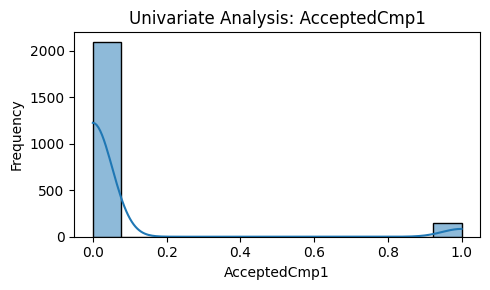

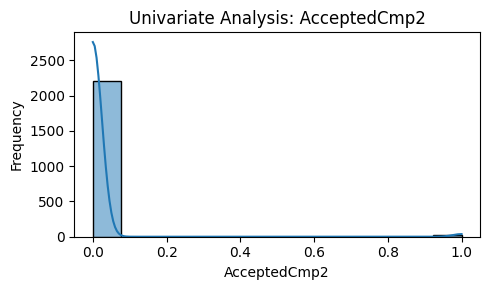

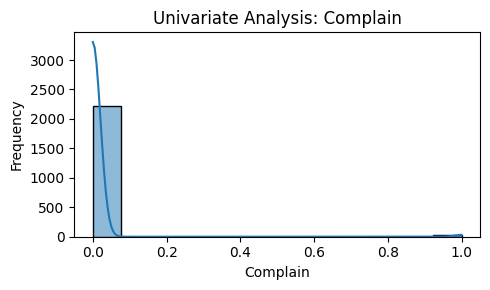

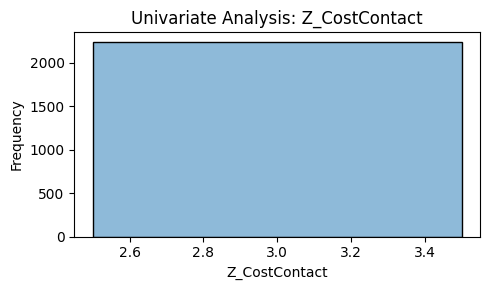

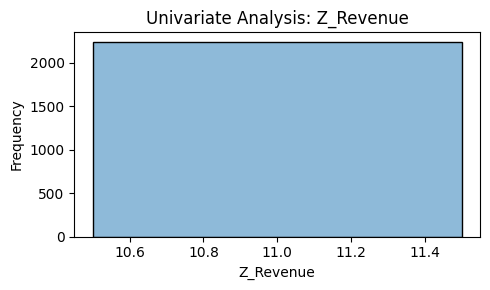

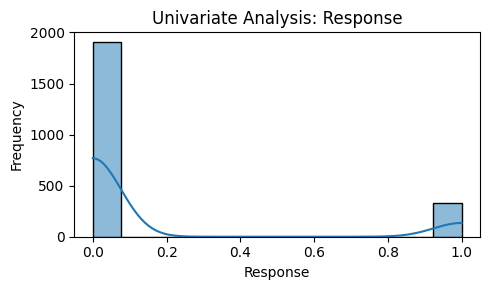

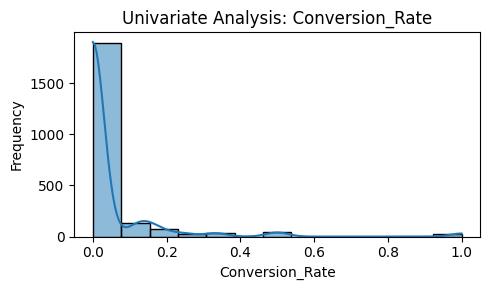

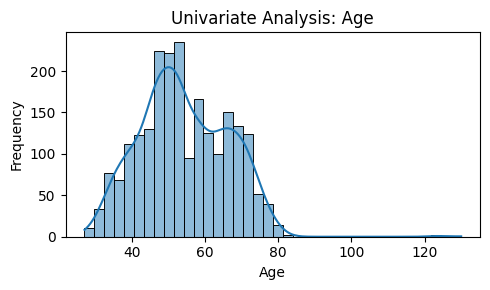

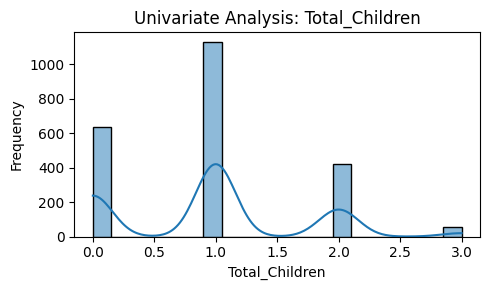

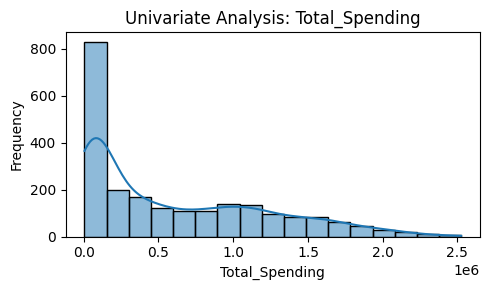

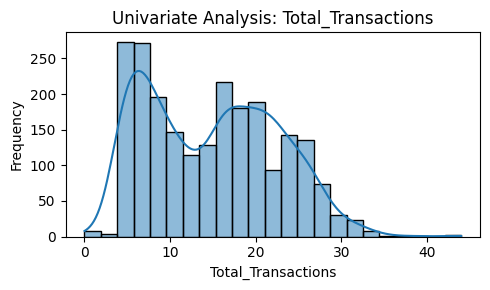

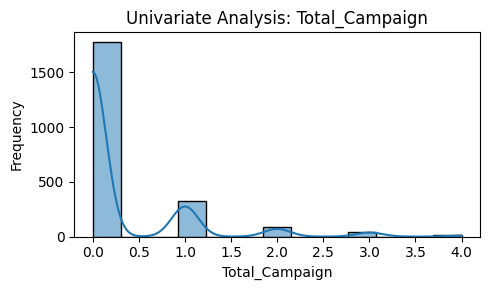

In [ ]:
for col in num_cols:
    plt.figure(figsize=(5, 3))  # Adjust the figsize as needed
    sns.histplot(df[col], kde=True)
    plt.title(f'Univariate Analysis: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()  # Add this line to improve spacing
    plt.show()

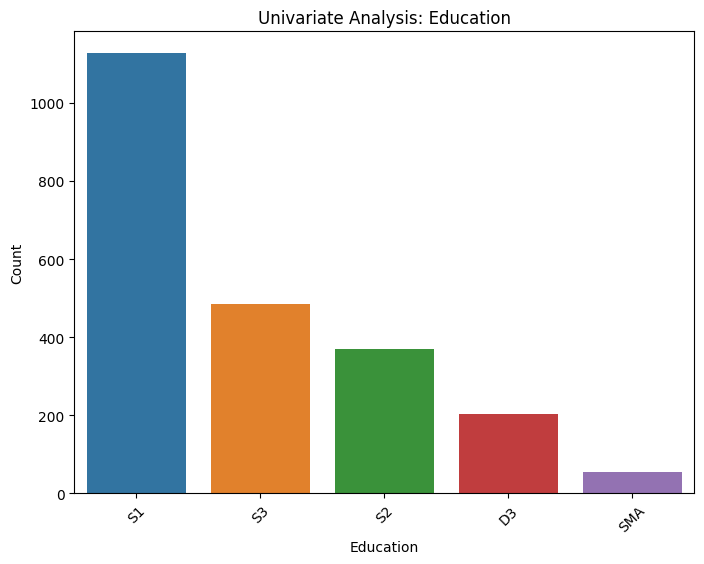

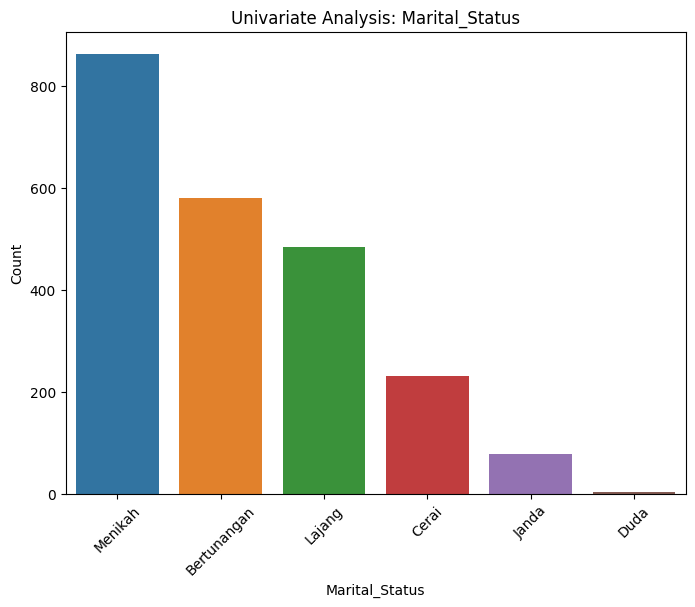

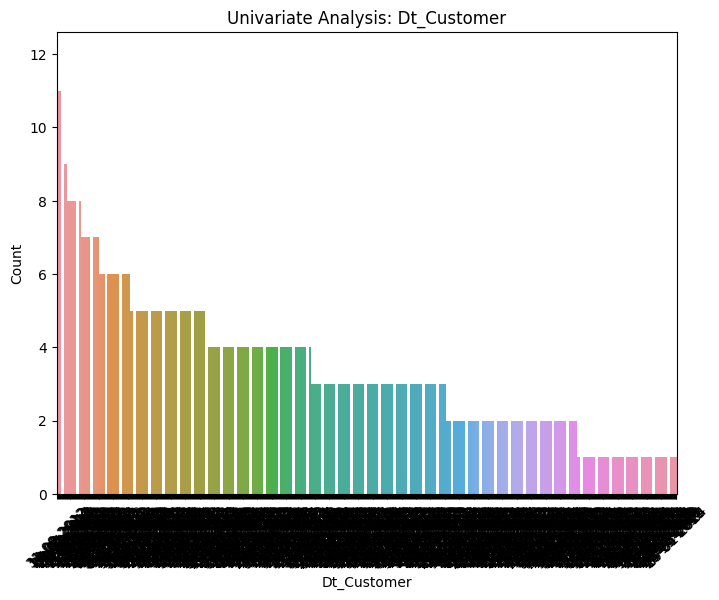

In [ ]:
# Perform Univariate Analysis for Categorical Columns
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Univariate Analysis: {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

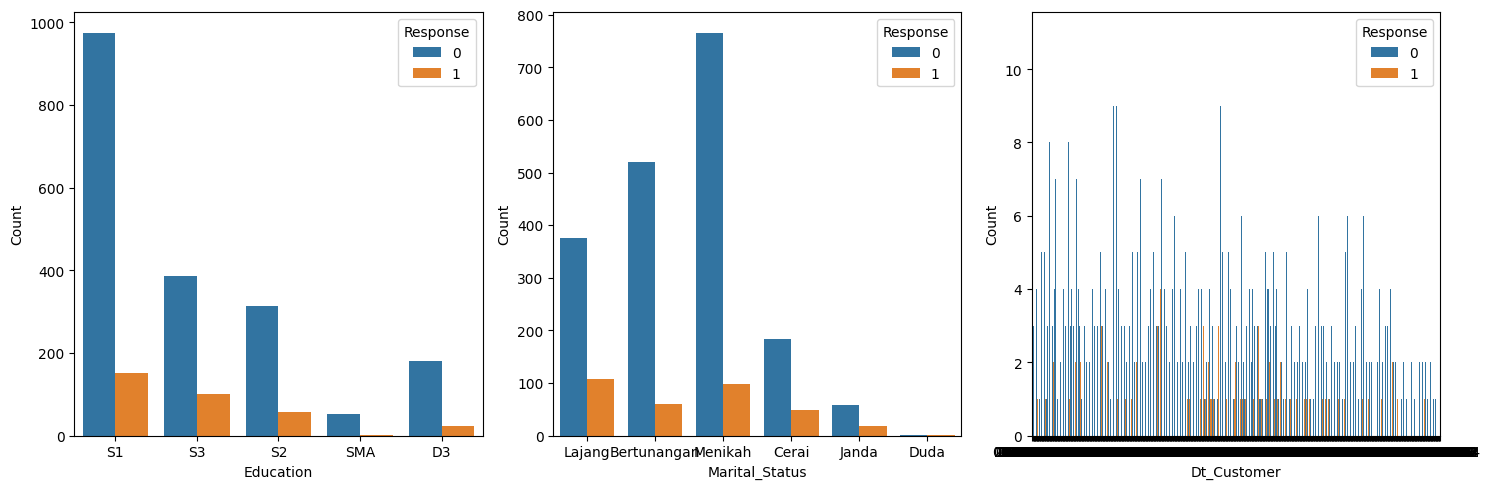

In [ ]:
# Univariate analysis for categorical columns
num_cat_cols = len(cat_cols)
num_rows = (num_cat_cols - 1) // 3 + 1
plt.figure(figsize=(15, 5*num_rows))
for i, col in enumerate(cat_cols):
    plt.subplot(num_rows, 3, i+1)
    sns.countplot(x=col, data=df, hue=df['Response'])
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

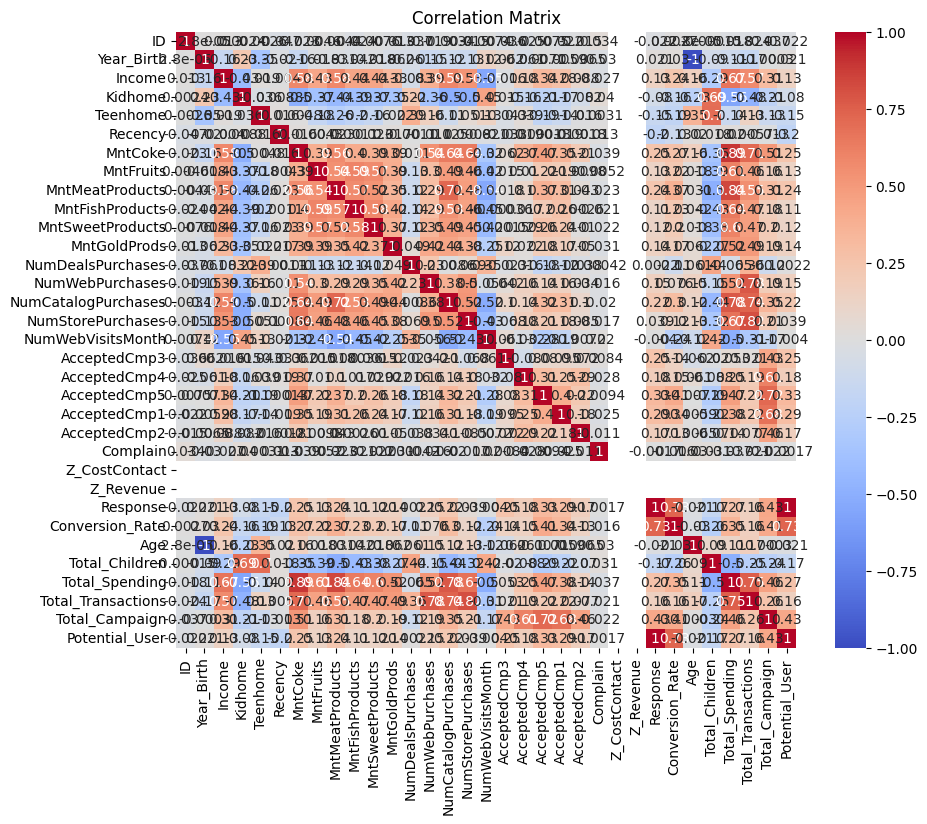

In [ ]:
# Correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

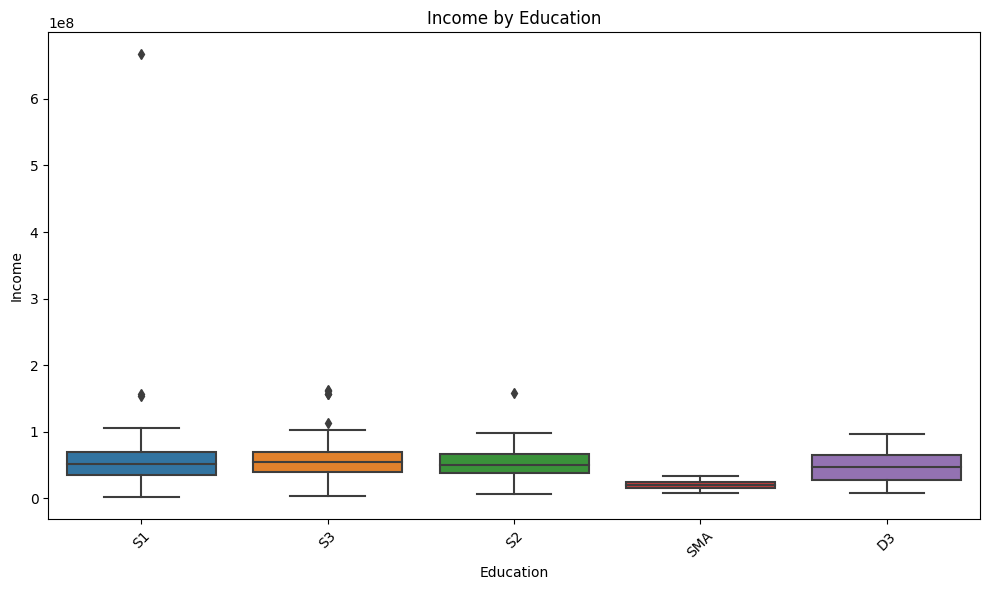

In [ ]:
# Box plot of Income by Education
plt.figure(figsize=(10, 6))
sns.boxplot(x='Education', y='Income', data=df)
plt.title("Income by Education")
plt.xlabel("Education")
plt.ylabel("Income")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

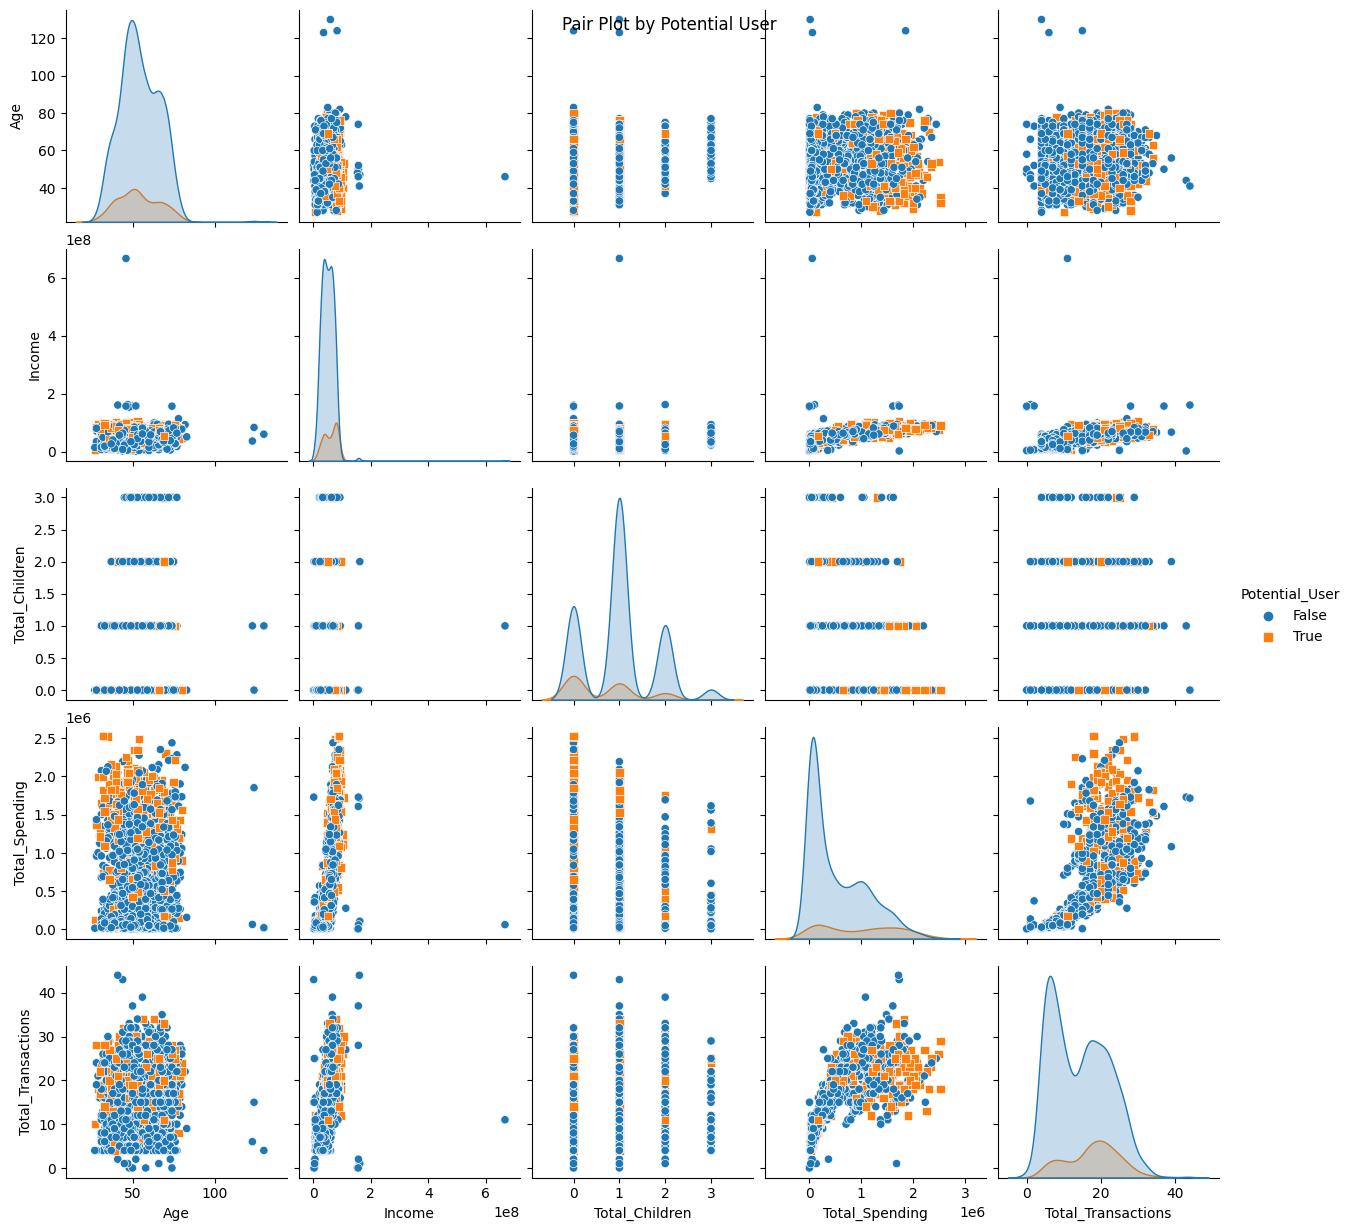

In [ ]:
# Pair plot
sns.pairplot(df[['Age', 'Income', 'Total_Children', 'Total_Spending', 'Total_Transactions', 'Potential_User']],
             hue='Potential_User', diag_kind='kde', markers=['o', 's'])
plt.suptitle("Pair Plot by Potential User")
plt.show()

# Data Cleaning & Preprocessing

In [ ]:
df_final = df.copy()

In [ ]:
missing_value = df_final.isna().sum()*100/len(df_final)
print(round(missing_value, 4).sort_values(ascending=False))

Income                 1.0714
Conversion_Rate        0.4911
Response               0.0000
AcceptedCmp4           0.0000
AcceptedCmp5           0.0000
AcceptedCmp1           0.0000
AcceptedCmp2           0.0000
Complain               0.0000
Z_CostContact          0.0000
Z_Revenue              0.0000
ID                     0.0000
NumWebVisitsMonth      0.0000
Age                    0.0000
Total_Children         0.0000
Total_Spending         0.0000
Total_Transactions     0.0000
Total_Campaign         0.0000
Age_Group              0.0000
AcceptedCmp3           0.0000
NumStorePurchases      0.0000
Year_Birth             0.0000
MntCoke                0.0000
Education              0.0000
Marital_Status         0.0000
Kidhome                0.0000
Teenhome               0.0000
Dt_Customer            0.0000
Recency                0.0000
MntFruits              0.0000
NumCatalogPurchases    0.0000
MntMeatProducts        0.0000
MntFishProducts        0.0000
MntSweetProducts       0.0000
MntGoldPro

In [ ]:
df_final['Income'] = df_final['Income'].fillna(df_final['Income'].median())
df_final['Conversion_Rate'] = df_final['Conversion_Rate'].fillna(df_final['Conversion_Rate'].median())


In [ ]:
missing_value = df_final.isna().sum()*100/len(df_final)
print(round(missing_value, 4).sort_values(ascending=False))

ID                     0.0
NumWebVisitsMonth      0.0
AcceptedCmp4           0.0
AcceptedCmp5           0.0
AcceptedCmp1           0.0
AcceptedCmp2           0.0
Complain               0.0
Z_CostContact          0.0
Z_Revenue              0.0
Response               0.0
Conversion_Rate        0.0
Age                    0.0
Total_Children         0.0
Total_Spending         0.0
Total_Transactions     0.0
Total_Campaign         0.0
Age_Group              0.0
AcceptedCmp3           0.0
NumStorePurchases      0.0
Year_Birth             0.0
NumCatalogPurchases    0.0
Education              0.0
Marital_Status         0.0
Income                 0.0
Kidhome                0.0
Teenhome               0.0
Dt_Customer            0.0
Recency                0.0
MntCoke                0.0
MntFruits              0.0
MntMeatProducts        0.0
MntFishProducts        0.0
MntSweetProducts       0.0
MntGoldProds           0.0
NumDealsPurchases      0.0
NumWebPurchases        0.0
Potential_User         0.0
d

In [ ]:
df_final.duplicated().sum()

0

In [ ]:
df_final.drop(['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5',
                'NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases',
                'MntCoke','MntFishProducts','MntFruits','MntMeatProducts','MntSweetProducts', 'MntGoldProds',
                'Kidhome','Teenhome', 'Response'], inplace=True, axis=1)

In [ ]:
from dython.nominal import associations

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 0 to 2239
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   ID                  2240 non-null   int64   
 1   Year_Birth          2240 non-null   int64   
 2   Education           2240 non-null   object  
 3   Marital_Status      2240 non-null   object  
 4   Income              2240 non-null   float64 
 5   Dt_Customer         2240 non-null   object  
 6   Recency             2240 non-null   int64   
 7   NumWebVisitsMonth   2240 non-null   int64   
 8   Complain            2240 non-null   int64   
 9   Z_CostContact       2240 non-null   int64   
 10  Z_Revenue           2240 non-null   int64   
 11  Conversion_Rate     2240 non-null   float64 
 12  Age                 2240 non-null   int64   
 13  Total_Children      2240 non-null   int64   
 14  Total_Spending      2240 non-null   int64   
 15  Total_Transactions  2240 non-null   in

In [ ]:
# Change data types of columns
df_final['Age_Group'] = df_final['Age_Group'].astype(str)  # Change to object (string)
df_final['Potential_User'] = df_final['Potential_User'].astype(int)  # Change to int

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

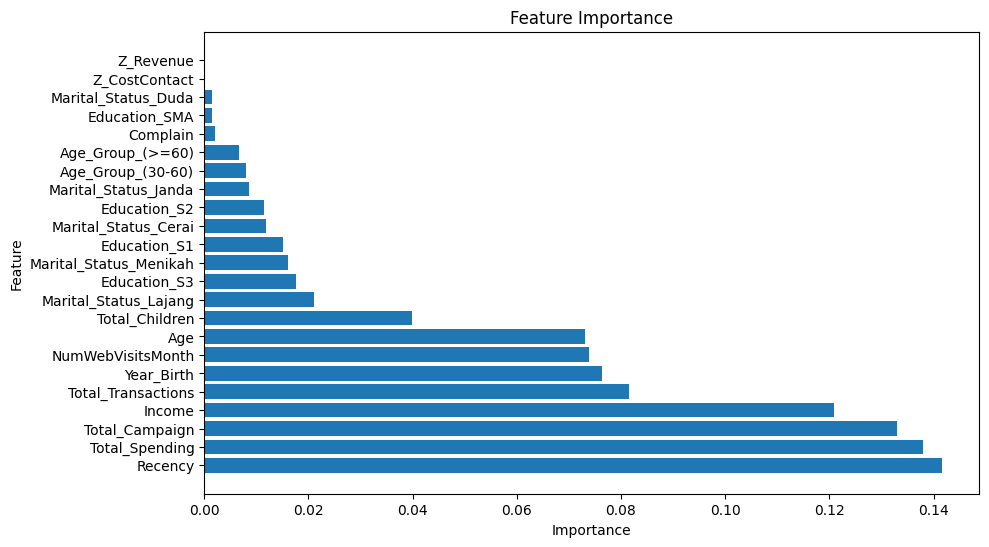

In [ ]:
# Separate features and target
X = df_final.drop(['Potential_User','Dt_Customer','Conversion_Rate','ID'], axis=1)  # Features excluding the target
y = df_final['Potential_User']  # Target variable

# Convert categorical features using One-Hot Encoding
categorical_columns = ['Education', 'Marital_Status','Age_Group']  # List of categorical columns
encoder = OneHotEncoder(drop='first', sparse=False)  # Drop first category to prevent multicollinearity
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_columns]))
X_encoded.columns = encoder.get_feature_names_out(categorical_columns)
X.drop(categorical_columns, axis=1, inplace=True)
X = pd.concat([X, X_encoded], axis=1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
selected_columns = ['Recency', 'Total_Spending', 'Total_Campaign', 'Income', 'Total_Transactions']
X = df_final[selected_columns]
y = df_final['Potential_User']

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select columns to be standardized
columns_to_standardize = ['Recency', 'Total_Spending', 'Total_Campaign', 'Income', 'Total_Transactions']

# Perform feature standardization
scaler = StandardScaler()
df_final[columns_to_standardize] = scaler.fit_transform(df_final[columns_to_standardize])

# Display the first few rows of the modified DataFrame
print(df_final.head())

     ID  Year_Birth Education Marital_Status    Income Dt_Customer   Recency  \
0  5524        1957        S1         Lajang  0.235696  04-09-2012  0.307039   
1  2174        1954        S1         Lajang -0.235454  08-03-2014 -0.383664   
2  4141        1965        S1    Bertunangan  0.773999  21-08-2013 -0.798086   
3  6182        1984        S1    Bertunangan -1.022355  10-02-2014 -0.798086   
4  5324        1981        S3        Menikah  0.241888  19-01-2014  1.550305   

   NumWebVisitsMonth  Complain  Z_CostContact  Z_Revenue  Conversion_Rate  \
0                  7         0              3         11         0.142857   
1                  5         0              3         11         0.000000   
2                  4         0              3         11         0.000000   
3                  6         0              3         11         0.000000   
4                  5         0              3         11         0.000000   

   Age  Total_Children  Total_Spending  Total_Transactio

In [ ]:
df_final.sample(20)

,ID,Year_Birth,Education,Marital_Status,Income,Dt_Customer,Recency,NumWebVisitsMonth,Complain,Z_CostContact,Z_Revenue,Conversion_Rate,Age,Total_Children,Total_Spending,Total_Transactions,Total_Campaign,Age_Group,Potential_User
59,8375,1968,S3,Menikah,0.148449,03-03-2014,0.479715,7,0,3,11,0.000000,55,1,-0.145816,0.539114,-0.439037,(30-60),0
1215,1506,1975,S1,Lajang,-0.402598,28-06-2013,-0.798086,6,0,3,11,0.166667,48,2,-0.773604,-0.503169,-0.439037,(30-60),1
927,3139,1982,D3,Lajang,0.873989,30-12-2013,0.134363,2,0,3,11,0.000000,41,0,2.401870,0.539114,1.035390,(30-60),0
369,2928,1975,S3,Lajang,0.015022,01-12-2012,0.479715,8,0,3,11,0.000000,48,1,0.638087,0.148258,-0.439037,(30-60),0
1776,7433,1985,S1,Lajang,-0.897956,29-08-2012,1.308559,8,0,3,11,0.000000,38,1,-0.732083,-0.372884,-0.439037,(30-60),0
487,5562,1974,S1,Menikah,0.313795,26-06-2013,1.481235,6,0,3,11,0.000000,49,1,0.214580,0.799685,-0.439037,(30-60),0
1159,640,1951,S1,Menikah,0.202379,11-03-2013,0.410645,5,0,3,11,0.000000,72,1,0.697876,1.320826,-0.439037,(>=60),0
1946,10676,1982,S1,Menikah,0.438353,02-11-2012,-1.592395,2,0,3,11,0.500000,41,0,0.942016,0.669399,-0.439037,(30-60),1
1465,10524,1963,S2,Cerai,-0.110336,20-06-2013,-0.694481,2,0,3,11,0.000000,60,1,0.314229,0.929970,-0.439037,(30-60),0
656,2564,1953,S1,Bertunangan,0.361133,04-01-2014,1.308559,6,0,3,11,0.000000,70,1,-0.732083,-0.633454,-0.439037,(>=60),0


In [ ]:
# Drop the specified columns
columns_to_drop = ['ID', 'Year_Birth', 'Dt_Customer']
df_final.drop(columns=columns_to_drop, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Apply label encoding to the categorical columns
categorical_columns = ['Education', 'Marital_Status', 'Age_Group']
for col in categorical_columns:
    df_final[col] = label_encoder.fit_transform(df_final[col])

# Display the first few rows of the modified DataFrame
df_final.head()

,Education,Marital_Status,Income,Recency,NumWebVisitsMonth,Complain,Z_CostContact,Z_Revenue,Conversion_Rate,Age,Total_Children,Total_Spending,Total_Transactions,Total_Campaign,Age_Group,Potential_User
0,1,4,0.235696,0.307039,7,0,3,11,0.142857,66,0,1.679417,1.320826,-0.439037,2,1
1,1,4,-0.235454,-0.383664,5,0,3,11,0.000000,69,2,-0.961275,-1.154596,-0.439037,2,0
2,1,0,0.773999,-0.798086,4,0,3,11,0.000000,58,0,0.282673,0.799685,-0.439037,1,0
3,1,0,-1.022355,-0.798086,6,0,3,11,0.000000,39,1,-0.918094,-0.894025,-0.439037,1,0
4,3,5,0.241888,1.550305,5,0,3,11,0.000000,42,1,-0.305254,0.539114,-0.439037,1,0


In [ ]:
# Replace NaN with median and infinity with a large value in 'Income' column
median_income = df_final['Income'].median()
max_income = df_final['Income'].max()

df_final['Income'].fillna(median_income, inplace=True)
df_final['Income'] = df_final['Income'].replace([np.inf, -np.inf], max_income)


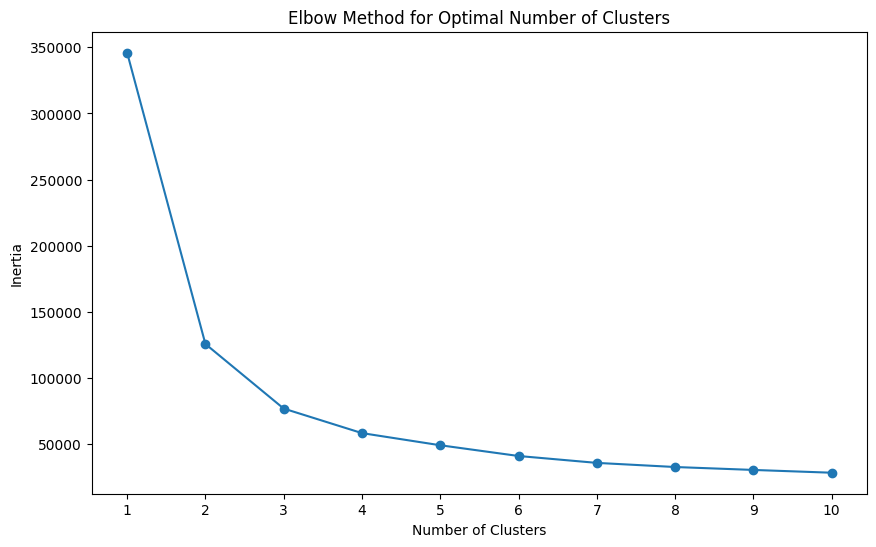

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select the columns for clustering
columns_for_clustering = ['Income', 'Recency', 'Total_Spending','Total_Campaign', 'Total_Transactions', 'Age', 'NumWebVisitsMonth']

# Create a list to store the inertia values
inertia_values = []

# Try different numbers of clusters and calculate inertia for each
for num_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(df_final[columns_for_clustering])
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(1, 11))
plt.show()


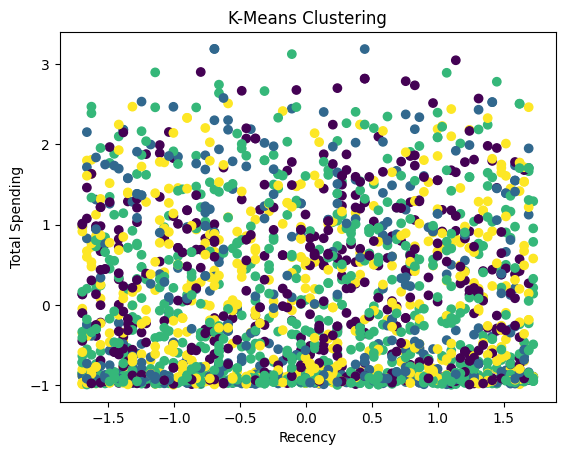

In [ ]:
# Select relevant features for clustering
features = ['Income', 'Recency', 'Total_Spending','Total_Campaign', 'Total_Transactions', 'Age', 'NumWebVisitsMonth']
data_for_clustering = df_final[features]

# Instantiate KMeans with the chosen number of clusters (e.g., 3)
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Fit KMeans to the data
kmeans.fit(data_for_clustering)

# Add cluster labels to the original DataFrame
df_final['Cluster_Labels'] = kmeans.labels_

# Visualize the clusters (e.g., for 2D visualization)
plt.scatter(data_for_clustering['Recency'], data_for_clustering['Total_Spending'], c=kmeans.labels_)
plt.xlabel('Recency')
plt.ylabel('Total Spending')
plt.title('K-Means Clustering')
plt.show()

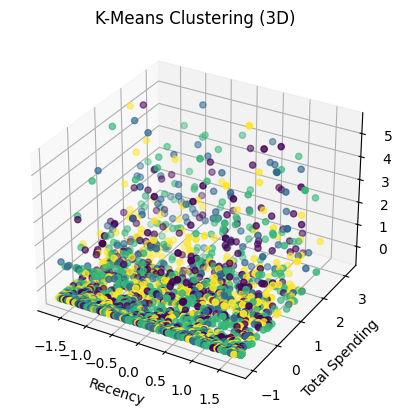

In [ ]:
features = ['Income', 'Recency', 'Total_Spending','Total_Campaign', 'Total_Transactions', 'Age', 'NumWebVisitsMonth']
data_for_clustering = df_final[features]

# Instantiate KMeans with the chosen number of clusters (e.g., 3)
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Fit KMeans to the data
kmeans.fit(data_for_clustering)

# Add cluster labels to the original DataFrame
df_final['Cluster_Labels'] = kmeans.labels_

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot data points with cluster labels
ax.scatter(data_for_clustering['Recency'], data_for_clustering['Total_Spending'], data_for_clustering['Total_Campaign'], c=kmeans.labels_)
ax.set_xlabel('Recency')
ax.set_ylabel('Total Spending')
ax.set_zlabel('Total Campaign')
ax.set_title('K-Means Clustering (3D)')

plt.show()

In [ ]:
cluster_counts = df_final['Cluster_Labels'].value_counts()
total_samples = len(df_final)

cluster_percentages = cluster_counts / total_samples * 100

print("Cluster Percentages:")
for cluster_label, percentage in cluster_percentages.items():
    print(f"Cluster {cluster_label}: {percentage:.2f}%")

Cluster Percentages:
Cluster 2: 36.21%
Cluster 3: 24.11%
Cluster 0: 20.76%
Cluster 1: 18.93%


In [ ]:
df_final['Cluster_Labels'] = kmeans.labels_
df_final.head()

,Education,Marital_Status,Income,Recency,NumWebVisitsMonth,Complain,Z_CostContact,Z_Revenue,Conversion_Rate,Age,Total_Children,Total_Spending,Total_Transactions,Total_Campaign,Age_Group,Potential_User,Cluster_Labels
0,1,4,0.235696,0.307039,7,0,3,11,0.142857,66,0,1.679417,1.320826,-0.439037,2,1,0
1,1,4,-0.235454,-0.383664,5,0,3,11,0.000000,69,2,-0.961275,-1.154596,-0.439037,2,0,0
2,1,0,0.773999,-0.798086,4,0,3,11,0.000000,58,0,0.282673,0.799685,-0.439037,1,0,3
3,1,0,-1.022355,-0.798086,6,0,3,11,0.000000,39,1,-0.918094,-0.894025,-0.439037,1,0,1
4,3,5,0.241888,1.550305,5,0,3,11,0.000000,42,1,-0.305254,0.539114,-0.439037,1,0,1


In [ ]:
df_age_clust = df_final.groupby(['Cluster_Labels', 'Age_Group']).agg({'Education':'count'}).reset_index()
df_age_clust = df_age_clust.rename(columns={'Education':'total_customers'})
df_age_clust['sum_customers'] = df_age_clust['total_customers'].sum()
df_age_clust['pct'] = round((df_age_clust['total_customers']/df_age_clust['sum_customers'])*100, 2)
df_age_clust

,Cluster_Labels,Age_Group,total_customers,sum_customers,pct
0,0,2,465,2240,20.76
1,1,0,15,2240,0.67
2,1,1,409,2240,18.26
3,2,1,811,2240,36.21
4,3,1,306,2240,13.66
5,3,2,234,2240,10.45


In [ ]:
high_valued_criteria = (df_final['Income'] > conversion_threshold) & (df_final['Total_Spending'] > conversion_threshold)
high_valued_clusters = df_final.loc[high_valued_criteria, 'Cluster_Labels'].value_counts()

print("High-Valued Customer Clusters:")
print(high_valued_clusters)


High-Valued Customer Clusters:
2    246
3    210
0    204
1    141
Name: Cluster_Labels, dtype: int64


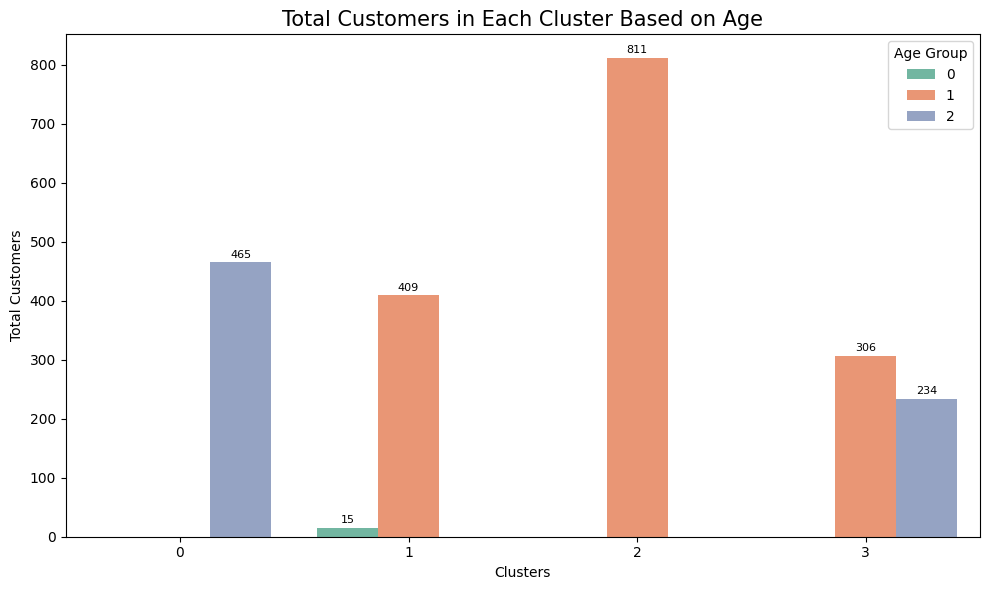

In [ ]:
# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Cluster_Labels', y='total_customers', data=df_age_clust, hue='Age_Group', palette='Set2')

plt.title("Total Customers in Each Cluster Based on Age", fontsize=15)
plt.xlabel("Clusters")
plt.ylabel("Total Customers")
plt.legend(title="Age Group")
plt.xticks(rotation=0)

# Display percentages on the bars
for container in ax.containers:
    plt.bar_label(container, label_type='edge', fontsize=8, padding=2)

plt.tight_layout()
plt.show()

The clustering analysis has grouped the customers into four distinct clusters: Cluster 2, Cluster 3, Cluster 0, and Cluster 1. Each cluster represents a different segment of customers based on their characteristics.

Cluster 2 appears to have the highest number of high-valued customers, with 811 individuals falling into this category. These customers exhibit higher income and total spending compared to the other clusters.

Following closely, Cluster 3 contains 540 high-valued customers. These customers also demonstrate a significant income and spending pattern, contributing to their high-value status.

In Cluster 0, there are 465 high-valued customers. These individuals showcase characteristics similar to the aforementioned clusters, indicating a strong potential for engagement with the business.

Finally, Cluster 1 includes 424 high-valued customers. Although slightly smaller in size compared to the other clusters, this group still holds promise in terms of their potential value to the business.

# Business Recomendation

Cluster 2: High-Valued Customers (811 individu)
Klaster ini memiliki jumlah pelanggan dengan nilai tinggi yang paling banyak. Karena pelanggan dalam klaster ini memiliki pendapatan dan total pengeluaran yang tinggi, ada beberapa langkah yang bisa diambil:

Premium Produk atau Layanan: Pertimbangkan untuk menawarkan produk atau layanan premium yang sesuai dengan preferensi dan kebutuhan pelanggan dalam klaster ini.
Program Loyalitas Tingkat Tinggi: Buat program loyalitas yang memberikan insentif atau manfaat eksklusif kepada pelanggan dalam klaster ini untuk mempertahankan hubungan jangka panjang.
Personalisasi: Gunakan data yang telah dianalisis untuk menyusun strategi personalisasi yang lebih mendalam, seperti rekomendasi produk yang disesuaikan dengan preferensi mereka.
Cluster 3: High-Valued Customers (540 individu)
Pelanggan dalam klaster ini juga memiliki pendapatan dan pengeluaran yang signifikan. Untuk meningkatkan hubungan dan nilai pelanggan dalam klaster ini:

Segmentasi Khusus: Identifikasi preferensi unik dan karakteristik pelanggan dalam klaster ini untuk mengembangkan kampanye pemasaran yang relevan.
Kolaborasi dan Partnership: Pertimbangkan kemitraan dengan merek lain yang juga menargetkan pelanggan dengan nilai tinggi untuk menciptakan nilai tambah yang lebih besar.
Servis Pelanggan Unggulan: Berikan layanan pelanggan yang istimewa dan responsif untuk membangun loyalitas pelanggan yang kuat.
Cluster 0: High-Valued Customers (465 individu)
Meskipun jumlahnya lebih rendah, pelanggan dalam klaster ini tetap memiliki potensi nilai yang signifikan:

Diversifikasi Penawaran: Tawarkan variasi produk atau layanan yang relevan untuk memenuhi berbagai kebutuhan pelanggan dalam klaster ini.
Konten Khusus: Buat konten pemasaran dan promosi yang khusus mengakomodasi minat dan preferensi pelanggan dalam klaster ini.
Penyegaran Pelanggan: Lakukan kampanye penyegaran pelanggan dengan menampilkan fitur-fitur baru atau peningkatan pada produk atau layanan yang telah mereka nikmati sebelumnya.
Cluster 1: High-Valued Customers (424 individu)
Klaster ini mungkin lebih kecil, tetapi tetap memiliki potensi untuk memberikan dampak positif:

Fokus pada Keunikan: Temukan apa yang membuat pelanggan dalam klaster ini unik dan kembangkan strategi yang menonjolkan hal tersebut.
Program Referral: Gunakan pelanggan dalam klaster ini untuk merekomendasikan produk atau layanan kepada orang lain, dengan memberikan insentif atau manfaat sebagai apresiasi.
Kampanye Re-Engagement: Lakukan kampanye khusus untuk mendekati pelanggan dalam klaster ini yang mungkin belum berinteraksi dalam beberapa waktu.